# Filling the gaps

*A practical guide for interpolation methods, from linear interpolation to linear regression, applied to design problems in Python.*

Studies and calculations must often be performed using incomplete data from various sources, for example when running power system studies with generator capabilities defined by a few data points in a table. In an ideal world, the manufacturers would always share well-defined, complete and accurate simulation models of their equipment. In reality, and this is especially true early in projects, the data is often severely lacking and is thus not sufficient for use in power system studies.

Interpolation techniques, such as linear, polynomial, nearest neighbor and linear regression, are useful methods designers and analysists can easily include and combine into their calculations and studies to compensate for such gaps.

## An example in renewable energy

An interesting example comes from reactive power capability of wind turbine generators; the maximum reactive power output of a wind turbine (capacitive or inductive) generally depends on both the active power it is currently generating, and the voltage at its terminal. Power system studies are often performed at a few fixed values of active power (ex.: Maximum and minimum active power), but a wind farm design optimization process sometimes requires the simulation of operation at various other values of active power (this heavily depends on local utility requirements).

The voltage at each wind turbine also varies significantly depending on how they are interconnected; the voltage at the turbine depends on the impedance on the collection system between itself and the substation's collector bus, the wind turbine's generation (active and reactive power), fixed or variable voltage transformation or regulation (ex.: a wind turbine transformer with its deenergized tap changer, an autotransformer voltage regulator, etc.), and the influence of other wind turbines and components on the collector.

No data in this article comes from real applications or manufacturer data, hypothetical data is used to present interesting interpolation opportunities. Reactive power capabilities of modern wind turbines vary; some exhibit higher reactive power capabilities as voltage increases and it's the opposite for others. For the current article, the capacitive reactive power capability (injecting) I am considering would look like the following figure:

![img](../media/2023-07-28_Expectation_xkcd.png)

These figures typically extend to an active power of 0.1 pu or 0.0 pu (usually with a no-wind option), and to negative reactive power capabilities (inductive, or absorbing).

> See [this article](https://www.esig.energy/wiki-main-page/reactive-power-capability-and-interconnection-requirements-for-pv-and-wind-plants/) for more details on reactive power capability and interconnection requirements for PV and wind plants.

We'll start by importing a few librairies and defining our data for the following examples. I use [pandas](https://pandas.pydata.org/) as much as possible; anytime I can put my data in tabular form. It's an immensely powerful and pratical library that is unfortunately not especially intuitive, at least in my opinion, hence using it whenever I can helps remain confortable with it. I would recommend the [Move from Excel to Python with Pandas](https://training.talkpython.fm/courses/move-from-excel-to-python-and-pandas) course from [Talk Python Training](https://training.talkpython.fm/) for anyone looking into getting confortable with `pandas`.

In [1]:
import pandas as pd

[calc_note](https://pypi.org/project/calc-note/) is a tiny library I developped to help print pandas DataFrames as markdown tables (they look better on the blog and when we convert notebooks with [nbconvert](https://github.com/jupyter/nbconvert)).

In [2]:
from calc_note.display import *

> When preparing an engineering deliverable with a [Jupyter Notebook](https://jupyter.org/), I like to [hide code cells](https://data-dive.com/jupyterlab-markdown-cells-include-variables/) (the input) and only show their output. Instead of showing the input code, I replace it with [LaTeX](https://www.latex-project.org/) formula and [Markdown](https://en.wikipedia.org/wiki/Markdown) explanation.

The following DataFrame is used to represent the generator's capacitive reactive power capabilities at various active power output and terminal voltages, with minimal details. It is used throughout the article to demonstrate various interpolation methods:

In [3]:
columns = (
    "P (pu)",  # Active power
    0.90,  # Voltage (pu)
    0.95,  # Voltage (pu)
    1.00,  # Voltage (pu)
    1.05,  # Voltage (pu)
    1.10,  # Voltage (pu)
)
qcap_max = pd.DataFrame(columns=columns)

In [4]:
values = {
    "P (pu)": 1.00,
    0.90: 1.00,  # MVAR (capacitive),
    0.95: 1.00,  # MVAR (capacitive),
    1.00: 2.20,  # MVAR (capacitive),
    1.05: 3.00,  # MVAR (capacitive),
    1.10: 2.50,  # MVAR (capacitive),
}
qcap_max = pd.concat([qcap_max, pd.DataFrame(values, index=[0])])

In [5]:
values = {
    "P (pu)": 0.95,
    0.90: 1.00,  # MVAR (capacitive),
    0.95: 2.00,  # MVAR (capacitive),
    1.00: 3.00,  # MVAR (capacitive),
    1.05: 3.00,  # MVAR (capacitive),
    1.10: 3.00,  # MVAR (capacitive),
}
qcap_max = pd.concat([qcap_max, pd.DataFrame(values, index=[0])])

In [6]:
values = {
    "P (pu)": 0.90,
    0.90: 1.50,  # MVAR (capacitive),
    0.95: 2.50,  # MVAR (capacitive),
    1.00: 3.00,  # MVAR (capacitive),
    1.05: 3.00,  # MVAR (capacitive),
    1.10: 3.00,  # MVAR (capacitive),
}
qcap_max = pd.concat([qcap_max, pd.DataFrame(values, index=[0])])

In [7]:
qcap_max.set_index("P (pu)", inplace=True)

In the following table (`qcap_max`), the index is the active power (in pu), the headers are the wind turbine voltages (in pu), and the values are the maximum capacitive reactive power output in these conditions (in MVAR):

In [8]:
show(qcap_max)

|   P (pu) |   0.9 |   0.95 |   1.0 |   1.05 |   1.1 |
|---------:|------:|-------:|------:|-------:|------:|
|     1    |   1   |    1   |   2.2 |      3 |   2.5 |
|     0.95 |   1   |    2   |   3   |      3 |   3   |
|     0.9  |   1.5 |    2.5 |   3   |      3 |   3   |

I would not consider this an adequate presentation for a client deliverable, but it will serve the following examples just fine.

[Matplotlib](https://matplotlib.org/) is used to plot the 2D data:

In [9]:
import matplotlib.pyplot as plt

The first figure presents the first line of data, i.e.: the maximum capacitive reactive power output at full active power, from 0.90 pu to 1.10 pu voltage:

In [10]:
qcap_max_fullpower = qcap_max.loc[1, :]

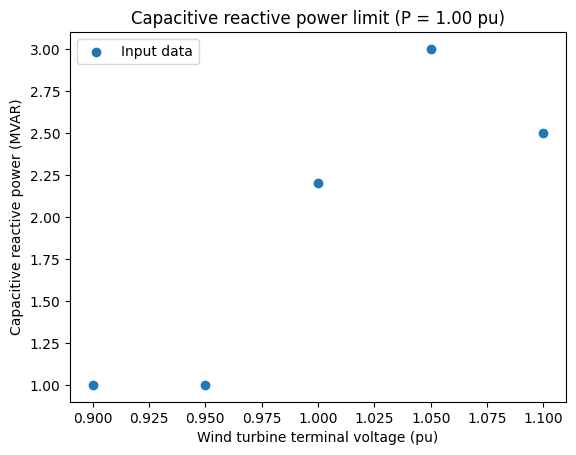

In [11]:
plt.scatter(
    qcap_max_fullpower.index,
    qcap_max_fullpower.values,
    label="Input data",
)

plt.title("Capacitive reactive power limit (P = 1.00 pu)")
plt.xlabel("Wind turbine terminal voltage (pu)")
plt.ylabel("Capacitive reactive power (MVAR)")
plt.legend(loc='upper left')
plt.show()

This may be sufficient for simplified calculations, but the wind turbines will *not* all be at the same voltage during operation, even if they are all at full active power. What would then be their reactive power limit at 1.047 pu voltage? 1.051 pu? Etc.? This is not enough to run a power flow study; intermediate points must be available.

Interestingly, simply using the [plot method](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html) on a `pandas` DataFrame or Series will generate a line graph of the data *with linear interpolation* between each point (a scatter plot can be specified, but it can only be used on DataFrames; not on Series).

> Note the semicolon at the end of the last line; without it, the following text appears between the code and the figure: `<Axes: title={'center': 'Capacitive reactive power limit (P = 1.00 pu)'}, xlabel='Wind turbine terminal voltage (pu)', ylabel='Capacitive reactive power (MVAR)'>`

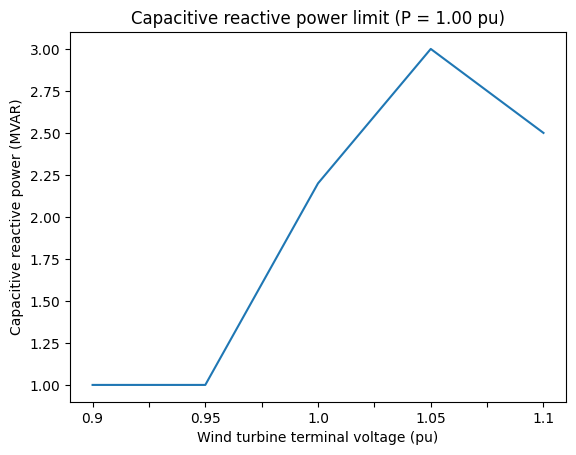

In [12]:
qcap_max_fullpower.plot(
    title="Capacitive reactive power limit (P = 1.00 pu)",
    xlabel="Wind turbine terminal voltage (pu)",
    ylabel="Capacitive reactive power (MVAR)",
);

While this figure is a bit interesting, it doesn't allow us to dynamically predict reactive power limits during execution; a prediction function is required.

## Nearest neighbor interpolation

The nearest neighbor interpolation may seem crude compared to the next methods but it's very efficient, especially with large amounts of data. I wouldn't use it in the current context because it would lead to simulation instability; a slight change in voltage would drastically impact reactive power limits, which in turns change the voltage, which change the limit, etc... This is neither realistic nor practical.

[NumPy](https://numpy.org/) describes itself as *the fundamental package for scientific computing with Python*, which seems rather accurate. It provides support for large, multi-dimensional arrays and matrices, along with a collection of high-level mathematical functions to operate on these arrays. Its versatility, efficiency, and extensive capabilities make it a fundamental tool for anyone working in the field of scientific computing with Python. It forms the foundation upon which many other specialized scientific libraries are built, making it a crucial part of the Python ecosystem for data analysis, modeling, and simulation tasks.

I'm using it here for its [linspace](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html) function, which returns evenly spaced numbers over an interval (for plotting).

In [13]:
import numpy as np

[Scipy](https://scipy.org/) is a library built on top of Numpy, which provides a wide range of scientific and technical computing functionalities. It includes modules for optimization, integration, interpolation, signal processing, linear algebra, statistical analysis, and more, making it a powerful toolset for various scientific and engineering applications.

In [14]:
from scipy.interpolate import interp1d

Since I have chosen to use the Pandas DataFrame's headers as data, they need to be converted to float before being used:

In [15]:
x_values = qcap_max_fullpower.index.astype("float64")
y_values = qcap_max_fullpower.values

To plot the results, 100 data points are generated betwen en 0.90 pu and 1.10 pu:

In [16]:
x = np.linspace(0.90, 1.10, 100)

In [17]:
nn_fit = interp1d(x_values, y_values, kind="nearest")

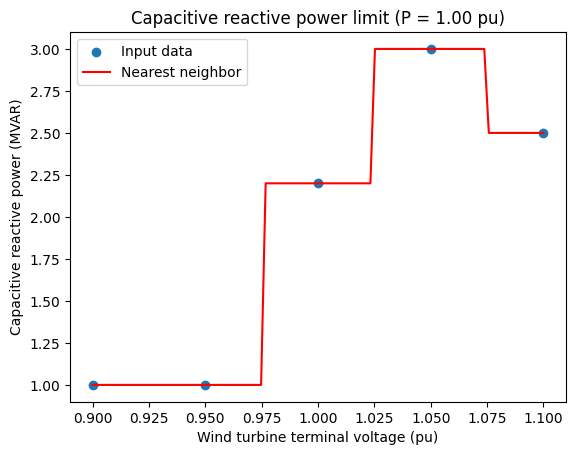

In [18]:
plt.scatter(x_values, y_values, label="Input data")
plt.plot(x, nn_fit(x), color="r", label="Nearest neighbor")
plt.title("Capacitive reactive power limit (P = 1.00 pu)")
plt.xlabel("Wind turbine terminal voltage (pu)")
plt.ylabel("Capacitive reactive power (MVAR)")
plt.legend()
plt.show()

## Linear interpolation

Linear interpolation is the mathematical equivalent of "connect the dots"; a straight line is drawn between each data point. It's simple, straighforward, but crude and sometimes unrealistic. Technical judgement is critical to select the best interpolation method to apply to specific problems, and the consequences of the errors in predictions must be understood.

Ironically, the linear interpolation method demonstrated here is also the most complicated method to implement in this article because each pair of dots is interpolated individually.

In [19]:
from numpy.polynomial.polynomial import Polynomial

[itertools](https://docs.python.org/3/library/itertools.html) is a module that provides a collection of fast, memory-efficient tools for creating iterators and working with iterable data structures. It includes functions like permutations, combinations, and infinite iterators to simplify common iteration tasks and optimize memory usage.

The [pairwise](https://docs.python.org/3/library/itertools.html#itertools.pairwise) function is used to get overlapping pairs of voltages in the input data, for linear interpolation.

In [20]:
from more_itertools import pairwise

Finally, I try to include [type hints](https://docs.python.org/3/library/typing.html) everytime I get a chance; they allow developers to specify and document the expected data types of variables, function arguments, and return values, improving code readability, catching errors early, and enabling better IDE support and code analysis.

In [21]:
from typing import List

The following function `linear_interpolation` takes 2 lists (x and y) and returns a list of predictions between each pair of points or dots in the input data. The `zip()` function aggregates both lists into a list of tuples of (x, y) (see [here](https://docs.python.org/dev/library/functions.html#zip) for some examples and details), and `pairwise()` returns the list in overlapping pairs (collections of 2 points, see [here](https://docs.python.org/dev/library/itertools.html#itertools.pairwise)).

In [22]:
def linear_interpolation(x: List[float], y: List[float]) -> List[tuple]:
    z = zip(x, y)
    f = []

    for z1, z2 in pairwise(z):
        func = Polynomial.fit((z1[0], z2[0]), (z1[1], z2[1]), deg=1)
        f.append(((z1[0], z2[0]), func))

    return f  # List of [(x_start, x_stop, predictor), ...]

Since the prediction model is different between each data point, the following function `qcap_max_fullpower_linear()` is used to return the prediction using the correct model depending on the input data `x` (the wind turbine voltage in pu, in our example):

In [23]:
def qcap_max_fullpower_linear(x: float) -> float:
    q = qcap_max_fullpower
    for z in linear_interpolation(q.index, q.values):
        if z[0][0] <= x <= z[0][1]:
            return z[1](x)

To plot the results, a prediction is made for each voltage in `x` by calling `qcap_max_fullpower_linear()`:

In [24]:
y = [qcap_max_fullpower_linear(i) for i in x]

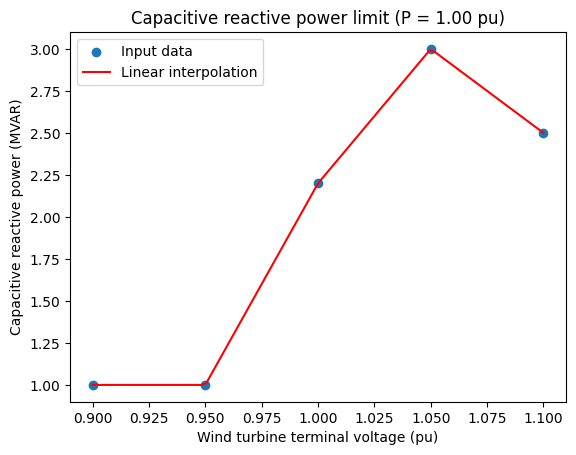

In [25]:
plt.scatter(
    qcap_max_fullpower.index,
    qcap_max_fullpower.values,
    label="Input data",
)
plt.plot(x, y, color="r", label="Linear interpolation")

plt.title("Capacitive reactive power limit (P = 1.00 pu)")
plt.xlabel("Wind turbine terminal voltage (pu)")
plt.ylabel("Capacitive reactive power (MVAR)")
plt.legend()
plt.show()

The prediction function can be used for any value between its limits, for example:

In [26]:
# Voltage (pu)
v = 1.023

# Maximum capacitive reactive power (MVAR)
q = qcap_max_fullpower_linear(v)

md(
    f"Max. cap. reactive power at full active power and a voltage of \
{v:.3f} pu: {q:.3f} MVAR"
)

Max. cap. reactive power at full active power and a voltage of 1.023 pu: 2.568 MVAR

The key issue with this interpolation method - for this particular example - is that it makes the reactive power limit excessively dependant on voltage around 1.05 pu; a slight increase or decrease in voltage significantly reduces the expected reactive power limit. Based on relevant experiences, I would expect the output around 1.05 pu voltage to be either parabolic, or with a relatively narrow, straight line at 3.00 MVAR.

The parabolic shape can be obtained with polynomial interpolation (with a higher degree than 1).

## Polynomial interpolation

Polynomial interpolation is fun, but swingy. It basically produces an equation of $n$ number of polynomials which are tuned to match the input data. $n$ is the *degree* of the interpolation; a number too low will produce poorly matched results, but one too high will oscillate. You generally want the lowest degree that produce sensible results.

We don't need to break the input data into pairs as in the linear interpolation; the polynomial variant takes the whole input into consideration. It is thus a lot more straightforward to implement.

It's good practice to try different degrees and choose the best one for each problem. In the following figure, a degree of 4 is the best fit; the overshoot after 1.05 pu voltage is minor and it generally fits the input data nicely.

/home/michel/.local/lib/python3.8/site-packages/numpy/polynomial/polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


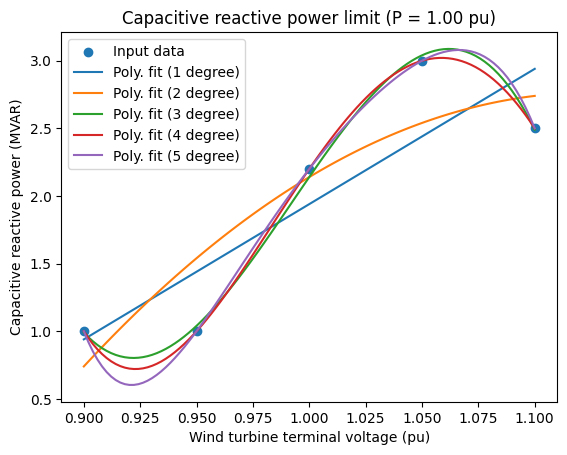

In [27]:
plt.scatter(x_values, y_values, label="Input data")

for degree in range(1, 6):
    polynomial_fit = Polynomial.fit(x_values, y_values, deg=degree)
    plt.plot(x, polynomial_fit(x), label=f"Poly. fit ({degree} degree)")

plt.title("Capacitive reactive power limit (P = 1.00 pu)")
plt.xlabel("Wind turbine terminal voltage (pu)")
plt.ylabel("Capacitive reactive power (MVAR)")
plt.legend()
plt.show();

The biggest issue with the above is that the fit between 0.90 pu and 0.95 pu makes no technical sense; the maximum capacitive reactive power output in that range should be flat, at 1.0 MVAR. A polynomial interpolation can't produce the expected behavior by itself; it must be combined with another method.

### Combining linear and polynomial fit

One way to get our flat prediction between 0.900 pu and 0.950 pu voltage is to combine a linear interpolation in this region with a polynomial interpolation elsewhere. Notice that the degree was reduced to 3 for the polynomial fit; removing the first data point made this fit simpler and thus adequate for this degree.

Another method is used at the end; linear regression is simply capped with `min()` and `max()`. With the current method, the polynomial interpolation is not affected by the first point (see figure below).

In [28]:
linear_fit = Polynomial.fit(x_values[:2], y_values[:2], deg=1)

In [29]:
degree = 3
polynomial_fit = Polynomial.fit(x_values[1:], y_values[1:], deg=degree)

The `combined_fit()` function contains a [list comprehension](https://docs.python.org/dev/tutorial/datastructures.html#list-comprehensions), which more concise and arguably more readable than the equivalent standard *for loop*:

In [30]:
def combined_fit(x: List[float]) -> List[float]:
    return [linear_fit(i) if i <= 0.95 else polynomial_fit(i) for i in x]

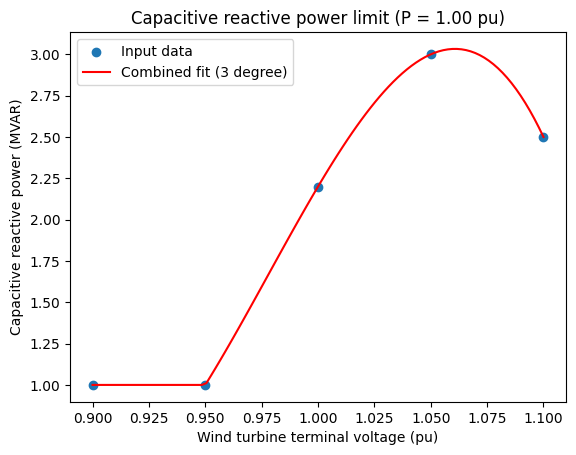

In [31]:
plt.scatter(x_values, y_values, label="Input data")
plt.plot(x, combined_fit(x), color="r", label=f"Combined fit ({degree} degree)")
plt.title("Capacitive reactive power limit (P = 1.00 pu)")
plt.xlabel("Wind turbine terminal voltage (pu)")
plt.ylabel("Capacitive reactive power (MVAR)")
plt.legend()
plt.show()

This looks like the best of both worlds; a realistic fit both at the highest and lowest reactive power limits, with a smooth, almost linear transition between both (i.e.: between 0.950 pu and 1.000 pu voltage).

However, the fact that the polynomial fit exceeds 3.00 MVAR - which is likely the correct absolute limit for this wind turbine considering the input data - is annoying. This can be capped by adjusting the `combined_fit()` function:

In [32]:
def combined_fit_capped(x: List[float]) -> List[float]:
    return [
        min(linear_fit(i), 3) if i <= 0.95 else min(polynomial_fit(i), 3) for i in x
    ]

Modifying the function this way - with a hardcoded cap of 3 MVAR - makes this function even more non-reuseable than it was before, with the 0.95 pu voltage separation. This should be handled differently for a real application, but it serves its purpose in its current form.

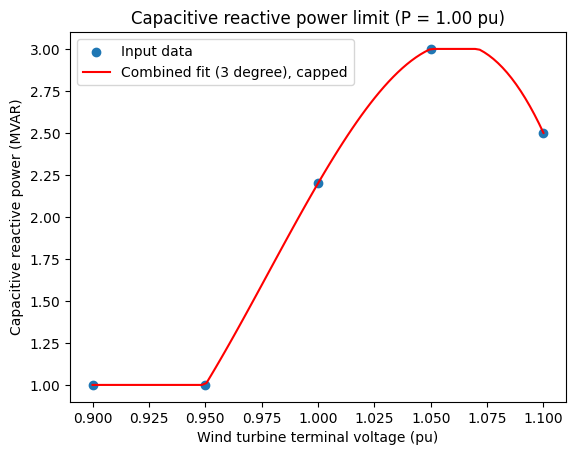

In [33]:
plt.scatter(x_values, y_values, label="Input data")
plt.plot(
    x,
    combined_fit_capped(x),
    color="r",
    label=f"Combined fit ({degree} degree), capped",
)
plt.title("Capacitive reactive power limit (P = 1.00 pu)")
plt.xlabel("Wind turbine terminal voltage (pu)")
plt.ylabel("Capacitive reactive power (MVAR)")
plt.legend()
plt.show()

This is probably as good as it can get with no additional data, or specific knowledge of the wind turbine's converter.

## Linear regression

Linear regression is a basic form of machine learning; it's a statistical technique used to model the relationship between a dependent variable (the one we want to predict) and one or more independent variables (the factors that influence the dependent variable). It assumes that the relationship between these variables can be approximated by a straight line or a hyperplane (for multiple independent variables) in a way that minimizes the errors between the actual observed values and the values predicted by the line or hyperplane. By finding the best-fitting line or hyperplane, linear regression enables us to make predictions or understand how changes in the independent variables affect the dependent variable.

The output with a single input variable (voltage) is essentially the same as with polynomial interpolation, but it becomes very convenient when multiple input variables are considered (voltage and active power).

In [34]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

We have already found that 4 degrees work great for this problem:

In [35]:
poly = PolynomialFeatures(degree=4)

The input voltages must be transformed for proper fitting with the polynomial features:

In [36]:
x_values_reshaped = poly.fit_transform(x_values.values.reshape(-1, 1))

In [37]:
ml_regressor = LinearRegression()

This is how the machine learning model is trained on the input data:

In [38]:
ml_regressor.fit(x_values_reshaped, y_values);

Once it is trained, it can predict new outputs (capacitive reactive power limits) based on new inputs (voltages):

In [39]:
ml_fit = ml_regressor.predict(poly.fit_transform(x.reshape(-1, 1)))

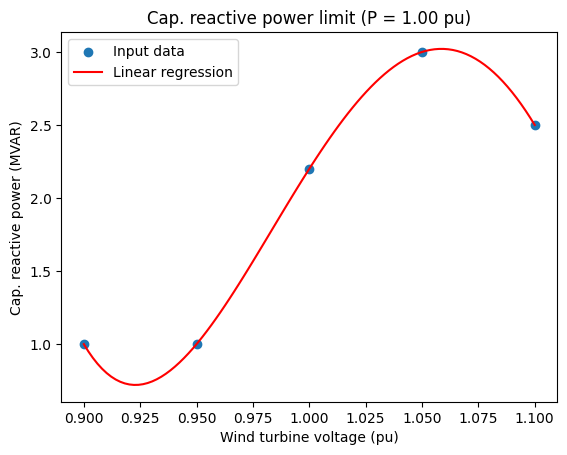

In [40]:
plt.scatter(x_values, y_values, label="Input data")
plt.plot(x, ml_fit, color="r", label="Linear regression")
plt.title("Cap. reactive power limit (P = 1.00 pu)")
plt.xlabel("Wind turbine voltage (pu)")
plt.ylabel("Cap. reactive power (MVAR)")
plt.legend()
plt.show()

As mentioned above, with just 1 input variable (voltage) this is the same as the polynomial interpolation we have already seen.

### Adding a dimension

Now it gets interesting; what if we don't want to build a model for each active power output, or if we want to simulate at intermediate values of active power (ex.: 0.982 pu)? No worries, linear regression can handle it!

The [mplot3d toolkit](https://matplotlib.org/stable/tutorials/toolkits/mplot3d.html) allows us to plot a static 3D scatter plot of the trained model. For dynamic plots I use [Plotly](https://plotly.com/python/plotly-express/), which can also be integrated into [NiceGUI](https://nicegui.io/documentation#plotly_element).

In [41]:
from mpl_toolkits.mplot3d import Axes3D

Adding another dimension (active power) requires a significant increase in polynomial features (from 4 to 14). I chose this number after incrementing until the result looked adequate.

In [42]:
poly_features = 14

In [43]:
poly = PolynomialFeatures(degree=poly_features)

In [44]:
v_range = qcap_max.columns.astype(float).values

In [45]:
p_range = qcap_max.index.astype(float).values

This list comprehension includes 2 *for loops*, in order to produce every combination of `v` and `p`:

In [46]:
v_p_range = [(v, p) for v in v_range for p in p_range]

In [47]:
q_range = [qcap_max.loc[p, v] for [v, p] in v_p_range]

In [48]:
v_p_range_reshaped = poly.fit_transform(v_p_range)

In [49]:
ml_regressor = LinearRegression()

In [50]:
ml_regressor.fit(v_p_range_reshaped, q_range);

Now that the model is trained, 100x100 (10e4) data points are generated to plot a smooth 3D graph of the predictions:

In [51]:
test_q = [
    (v, p) for v in np.linspace(0.9, 1.1, 100) for p in np.linspace(0.9, 1.0, 100)
]
test_q_ = poly.fit_transform(test_q)

In [52]:
ml_fit = ml_regressor.predict(test_q_)

In [53]:
test_qvar = [[x[0], x[1], ml_fit[i]] for i, x in enumerate(test_q)]
df_qvar = pd.DataFrame(test_qvar, columns=["V (pu)", "P (MW)", "Q (MVAR)"])

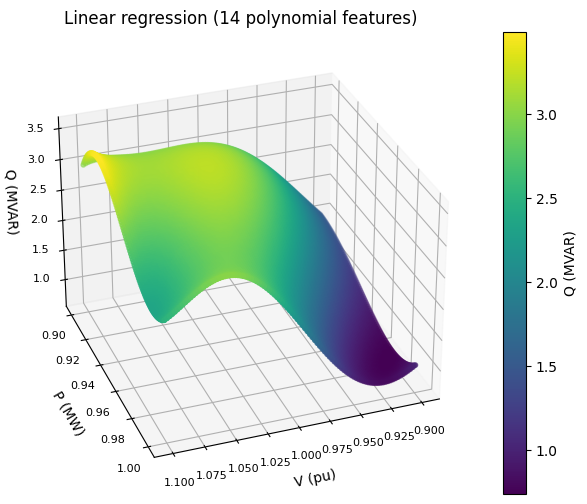

In [54]:
# Create a scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

# Scatter plot
sc = ax.scatter(
    df_qvar["V (pu)"],
    df_qvar["P (MW)"],
    df_qvar["Q (MVAR)"],
    c=df_qvar["Q (MVAR)"],
    cmap="viridis",
    s=10,
)

# Set labels and title
ax.set_xlabel("V (pu)")
ax.set_ylabel("P (MW)")
ax.set_zlabel("Q (MVAR)")
ax.set_title(f"Linear regression ({poly_features} polynomial features)")

# Add a color bar
cbar = fig.colorbar(sc, ax=ax, label="Q (MVAR)")

# Set layout
ax.view_init(azim=70, elev=30)
ax.tick_params(labelsize=8)

# Show the plot
plt.show()

This smooth, continuous presentation looks pretty, but it's a bit hard to gauge its adequacy. In the next and last example, I used the following tricks to determine that a degree of 16 was even better:

1. I plotted fewer points to see the individual dots;
2. I added big dots for the original data;
3. I used plotly during development to have a dynamic figure.

## Reusable model

This is an example of a `Model` class that handles training, prediction and plotting of the linear regression model in 3 dimensions, with capacitive reactive power limited to the minimum and maximum values provided in the input. This could be imported and used easily in a power flow script or notebook using one of the various Python libraries for this purpose (or a commercial software with a Python API).

In [55]:
class Model:
    def __init__(self, name: str, qcap_max: pd.DataFrame, poly_features: int = 16):
        self.name = name
        self.qcap_max = qcap_max
        self.min = qcap_max.values.min()
        self.max = qcap_max.values.max()

        self.extract_input_data()

        self.poly = PolynomialFeatures(degree=poly_features)
        self.poly_features = poly_features
        self.train()

    def extract_input_data(self):
        """Using the same methods as before, extract the input data."""
        v_range = self.qcap_max.columns.astype(float).values
        p_range = self.qcap_max.index.astype(float).values
        self.v_p_range = [(v, p) for v in v_range for p in p_range]
        self.q_range = [self.qcap_max.loc[p, v] for v, p in self.v_p_range]

    def cut(self, x: float) -> float:
        """Returns `x` with an upper limit of `maximum` and a lower
        limit of `minimum`.
        """
        return min(max(x, self.min), self.max)

    def train(self):
        """Make the regressor fit the input data."""
        v_p_range_reshaped = self.poly.fit_transform(self.v_p_range)
        self.ml = ml_regressor = LinearRegression()
        self.ml.fit(v_p_range_reshaped, self.q_range)

    def predict(self, target: List[List[float]]) -> List[float]:
        """Predicts the maximum reactive power output for a list of
        combinations of [voltage, active power].
        """
        prediction = list(self.ml.predict(self.poly.fit_transform(target)))
        return [self.cut(x) for x in prediction]

    def predict_one(self, v_pu: float, p_pu: float) -> float:
        """Predicts the maximum reactive power output for a
        combination of voltage and active power.
        """
        prediction = list(
            self.ml.predict(
                self.poly.fit_transform(
                    [
                        [v_pu, p_pu],
                    ]
                )
            )
        )
        return prediction[0]

    def plot(self, density: int = 20):
        """Creates a static figure to help validate the model."""
        # Input data as big dots
        q_range_input = [
            [x[0], x[1], self.q_range[i], 100] for i, x in enumerate(self.v_p_range)
        ]
        df_input = pd.DataFrame(
            q_range_input, columns=["V (pu)", "P (MW)", "Q (MVAR)", "size"]
        )

        # Interpolated data as small dots
        v_p_range = [
            (v, p)
            for v in np.linspace(0.9, 1.1, density)  # Should not be hardcoded
            for p in np.linspace(0.9, 1.0, density)  # Should not be hardcoded
        ]
        output_q = self.predict(v_p_range)
        q_range_interpo = [
            [x[0], x[1], output_q[i], 10] for i, x in enumerate(v_p_range)
        ]
        df_interpo = pd.DataFrame(
            q_range_interpo, columns=["V (pu)", "P (MW)", "Q (MVAR)", "size"]
        )

        # Combined both in a single dataframe
        df = pd.concat([df_input, df_interpo])

        # Create a scatter plot
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection="3d")

        # Scatter plot for input data
        sc_input = ax.scatter(
            df_input["V (pu)"],
            df_input["P (MW)"],
            df_input["Q (MVAR)"],
            c=df_input["Q (MVAR)"],
            cmap="viridis",
            s=df_input["size"],
        )

        # Scatter plot for interpolated data
        sc_interpo = ax.scatter(
            df_interpo["V (pu)"],
            df_interpo["P (MW)"],
            df_interpo["Q (MVAR)"],
            c=df_interpo["Q (MVAR)"],
            cmap="viridis",
            s=df_interpo["size"],
            alpha=0.5,
        )

        # Set labels and title
        ax.set_xlabel("V (pu)", fontsize=8)
        ax.set_ylabel("P (MW)", fontsize=8)
        ax.set_zlabel("Q (MVAR)", fontsize=8)
        ax.set_title(f"{self.name} ({self.poly_features} polynomial features)")

        # Add a color bar
        cbar = fig.colorbar(sc_input, ax=ax, label="Q (MVAR)")

        # Set layout
        ax.view_init(azim=70, elev=30)
        ax.tick_params(labelsize=8)

        # Show the plot
        plt.show()

An object is created with the initial input data:

In [56]:
m = Model("Linear regression", qcap_max, poly_features=16)

Here's the resulting static plot:

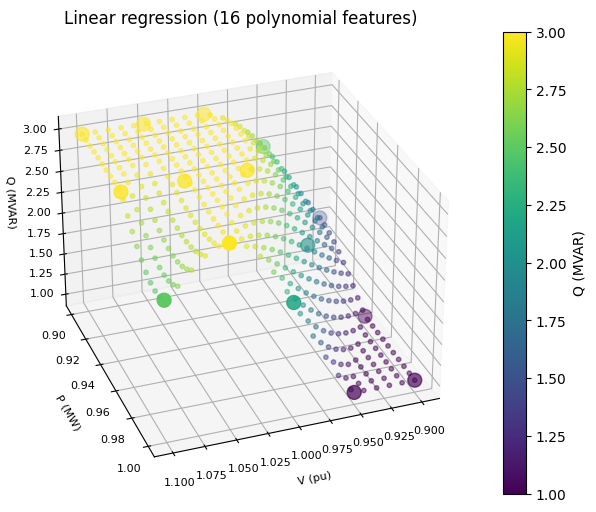

In [57]:
m.plot(density=20)

Predicting output on arrays would be more efficient, but the `Model` class includes a convenience method for doing a single prediction with descriptive arguments:

In [58]:
v = 1.065  # pu
p = 0.981  # pu

md(
    f"At a voltage of {v} pu, and an active power of {p} pu, the wind \
turbine can output a capacitive reactive power of at most \
{m.predict_one(v_pu=v, p_pu=p):.3f} MVAR."
)

At a voltage of 1.065 pu, and an active power of 0.981 pu, the wind turbine can output a capacitive reactive power of at most 2.809 MVAR.

## Conclusion

Those are just a few of the numerous methods designers and analysists can use to enhance studies and calculations. When I started learning about those techniques, I was amazed at how easy they are to integrate to my process once I made the shift to Python for tasks previously accomplished with spreadsheets and commercial power system softwares. I still use those everyday, but having more tools is always valuable.

I try to always use the simplest tool that can do the job well enough for the current need, and I believe the last example in this article fits this goal.

I hope this article will be useful and interesting for some readers, but I'm reassured by the fact that it certainly would have been for my past self, and most likely for my future self as well!

# TMP